# Travel Routing Example

In [67]:
import numpy
from concrete import fhe
import geopandas
import networkx 
import matplotlib.pyplot as plt


## Data Extraction

The data used as example in this notebook are extracted from [overpass-turbo](https://overpass-turbo.eu) using the following query :

```
    (
      way
        ["highway"="secondary"]
        (48.874256063816,2.3389828205109,48.876909238658,2.3433548212051);
      way
        ["highway"="tertiary"]
        (48.874256063816,2.3389828205109,48.876909238658,2.3433548212051);
      way
        ["highway"="residential"]
        (48.874256063816,2.3389828205109,48.876909238658,2.3433548212051);
      way
        ["highway"="pedestrian"]
        (48.874256063816,2.3389828205109,48.876909238658,2.3433548212051);
    );
    (
      ._;
      >;
    );
    out;
```

We then processed the data using [QGIS](https://www.qgis.org/fr/site/) to split lines in order to make the resulting graph connected.

Finaly, the boundaries of each way and the distances are computed using the above code.

In [64]:
import geopandas
ways = geopandas.read_file("data/paris_quadratic_edges.geojson")
edges = ways.explode(index_parts=False)[["id", "name", "geometry"]]
edges.index.name = "way_id"
edges = edges.reset_index()
nodes = geopandas.GeoSeries(edges.boundary.explode(index_parts=False).geometry.unique())
rel = edges.sjoin(nodes.to_frame())
rel.rename(columns={"index_right": "node_id"}, inplace=True)
assert (rel.groupby("way_id")["node_id"].nunique() == 2).all()

## useful for the plot
nodes = geopandas.GeoDataFrame(nodes, columns=['geometry'])
nodes['node_id'] = nodes.reset_index().index


Mettre une autre explication

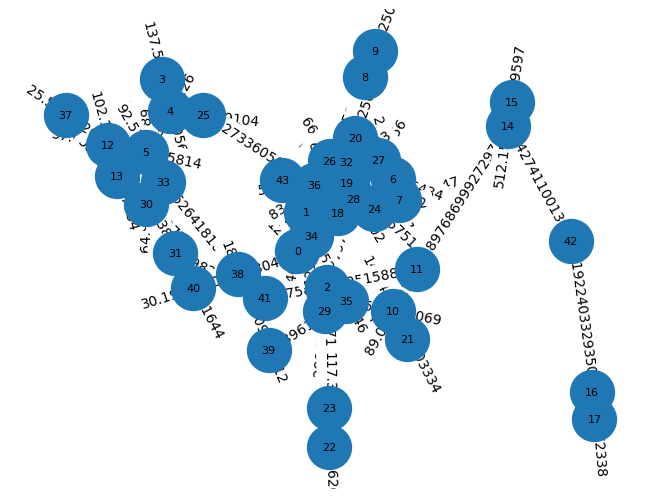

In [68]:
gdf = rel.to_crs("epsg:2154")

# Creation du graph nx
graph = networkx.Graph()

# Ajout des nodes
for node in gdf['node_id'].unique():
    graph.add_node(node)

# Ajout des edges et des poids
for idx in gdf['way_id'].unique():
    node_id1, node_id2 = gdf.loc[idx]['node_id']
    way_length = gdf.loc[idx]['geometry'].iloc[0].length
    graph.add_edge(node_id1, node_id2, weight=way_length)

    


## Setting up Server Data

The server owns map data.
The routes network is represented by its weighted adjacency matrix W: $W_{i, j}$ is the distance between nodes $i$ and $j$ if there is an edge between them, and infinity otherwise.

In [18]:
N_BITS = 10
inf = 2**N_BITS - 1  # infinity
# Origin x Destination -> Weight of edge (infinite if no edge)
weights = networkx.to_numpy_array(graph)
weights[weights == 0] = inf
numpy.fill_diagonal(weights, 0, wrap=False)
N_NODES = weights.shape[0]
assert weights.shape[0] == weights.shape[1]
assert (weights == weights.T).all()
assert (weights.diagonal() == 0).all()
weights

array([[   0.        ,   82.40761603,   46.17772315, ..., 1023.        ,
        1023.        ,   79.75564396],
       [  82.40761603,    0.        , 1023.        , ..., 1023.        ,
        1023.        , 1023.        ],
       [  46.17772315, 1023.        ,    0.        , ..., 1023.        ,
        1023.        , 1023.        ],
       ...,
       [1023.        , 1023.        , 1023.        , ...,    0.        ,
        1023.        , 1023.        ],
       [1023.        , 1023.        , 1023.        , ..., 1023.        ,
           0.        , 1023.        ],
       [  79.75564396, 1023.        , 1023.        , ..., 1023.        ,
        1023.        ,    0.        ]])

The server than pre-computes shortest paths between all OD pairs (origin and destination). The routing information is stored in a matrix M: $M_{i,j}$ is the next node to visit on the shortest path from node $i$ to node $j$.

In [19]:
from dijkstra import Dijkstra
router = Dijkstra(weights)
# Matrix of origin x destination -> next node on shortest path
next_nodes = router.get_all_shortest_paths()[:, :, 1]


Private Travel Routing than consist of oblivious transfer of an element of $M$. This is done in Zama via a TableLookup of the flatten matrix $M$.

In [21]:
routes = fhe.LookupTable(next_nodes.flatten())

@fhe.compiler({"origin": "encrypted", "destination": "encrypted"})
def route(origin, destination):
    return routes[N_NODES * origin + destination]


circuit = route.compile([(0, N_NODES - 1), (N_NODES - 1, 0)])

## Client

The client can stream the routing information privately by requesting the next node iteratively. For maximum privacy, the client can keep asking for next nodes even once the full shortest path is retrieved to hide information about the length of the route. 

In [22]:
circuit.client.keys.generate()


def shortest_path(origin, destination):
    path = [origin, ]
    o, d = circuit.encrypt(origin, destination)
    for _ in range(N_NODES - 1):
        # Careful: breaking early could lead to information leak
        if origin == destination:
            break
        o = circuit.run(o, d)
        origin = circuit.decrypt(o)
        path.append(origin)
    return path

## Benchmarks

In [ ]:
%%timeit -r 1 -n 1
shortest_path(0, 7)

In [66]:
shortest_path(22, 28)

[22, 23, 2, 28]

In [65]:
# print the edges
m = rel.explore(
    scheme="naturalbreaks",  
    tooltip="name", 
    popup=["name"], 
    name="Quadratic-Paris", 
)


# print the nodes
nodes.explore(
    m=m,  
    color="red",  
    marker_kwds=dict(radius=5, fill=True, name='node_id'),  
    tooltip="node_id",  
    tooltip_kwds=dict(labels=False),  
)


m 